In [172]:
from wfdb import rdsamp, rdrecord, rdann
from scipy.io.wavfile import write
import matplotlib.pyplot as plt
import numpy as np

In [72]:
signal, fields = rdsamp('data/drive15', channels=[0])

ecg = signal[:,0].flatten()
sampling_rate = 62
ecg_time = [i / sampling_rate for i in range(len(ecg))]

In [73]:
def detect_peaks(ecg):
  peaks = []
  for i in range(1, len(ecg) - 1):
      if ecg[i] > ecg[i-1] and ecg[i] > ecg[i+1]:
          peaks.append(i)
  return peaks

def detect_r_peaks(ecg, peaks = None, threshold = 0.5, first_only = False):
  if peaks is None:
      peaks = detect_peaks(ecg)

  r_peaks = []
  for peak in peaks:
      if ecg[peak] > threshold:
        if first_only:
          return peak
        else:
          r_peaks.append(peak)
  return r_peaks

In [74]:
def plot_segment(ecg, start_time, end_time, r_peaks = None, sampling_rate = 62, title = None):
  time = [i / sampling_rate for i in range(len(ecg))]
  time_segment = time[sampling_rate * start_time:sampling_rate * end_time]
  ecg_segment = ecg[sampling_rate * start_time:sampling_rate * end_time]

  plt.plot(time_segment, ecg_segment)
  
  plt.gcf().set_size_inches(12, 3)

  if r_peaks is not None:
    for i in [i for i in r_peaks if i >= sampling_rate * start_time and i < sampling_rate * end_time]:

      plt.axvline(x=time[i], color='r', alpha=0.35)

  
  if title is not None:
    plt.title(title)
  plt.xlabel('Time [s]')
  plt.ylabel('Amplitude [mV]')
  plt.show()

In [75]:
# find a 50 second segment with abnormal number of R peaks
def find_segment_with_abnormal_r_peaks(r_peak_locs, sampling_rate, most):
  # set initial value to the number of R peaks in the first 50 seconds
  max_r_peaks = len([i for i in r_peak_locs if i < sampling_rate * 50])
  max_r_peaks_segment = None
  for i in range(0, len(ecg) - sampling_rate * 50):
    r_peaks_in_segment = [j for j in r_peak_locs if j >= i and j < i + sampling_rate * 50]
    if most:
      if len(r_peaks_in_segment) > max_r_peaks:
          max_r_peaks = len(r_peaks_in_segment)
          max_r_peaks_segment = i
    else:
      if len(r_peaks_in_segment) < max_r_peaks:
          max_r_peaks = len(r_peaks_in_segment)
          max_r_peaks_segment = i

  print('Most/least R peaks: {}'.format(max_r_peaks))
  print('Time of the segment with the most/least R peaks: {} s'.format(max_r_peaks_segment / sampling_rate))
          
  return max_r_peaks_segment // sampling_rate


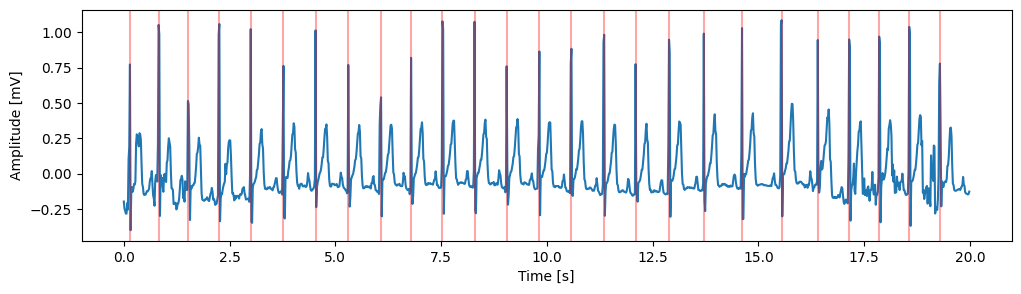

In [76]:
# find the peaks
peaks = detect_peaks(ecg)

# find the R peaks
r_peaks = detect_r_peaks(ecg, peaks)

plot_segment(ecg, 0, 20, r_peaks)

In [77]:
# calculate the heart rate
def calculate_heart_rate(r_peaks, sampling_rate):
  heart_rate = []
  for i in range(1, len(r_peaks)):
      heart_rate.append(60 * sampling_rate / (r_peaks[i] - r_peaks[i-1]))
  
  return sum(heart_rate) / len(heart_rate)

heart_rate = calculate_heart_rate(r_peaks, sampling_rate)
print('Heart rate: {:.2f} bpm'.format(heart_rate))

Heart rate: 110.03 bpm


Most/least R peaks: 46
Time of the segment with the most/least R peaks: 890.7903225806451 s
Most/least R peaks: 102
Time of the segment with the most/least R peaks: 938.6935483870968 s


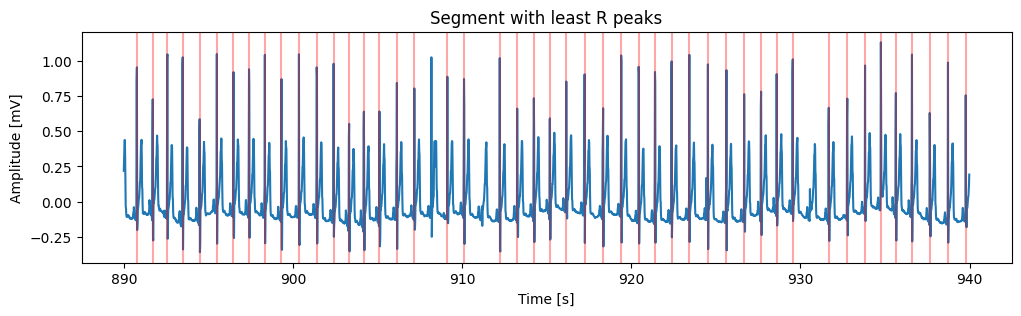

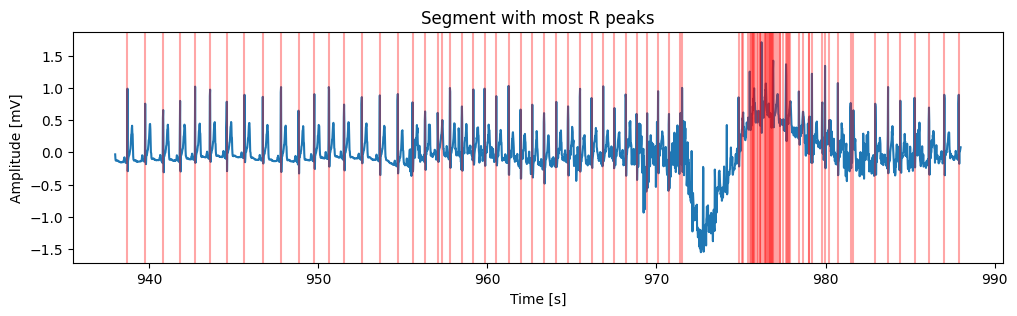

In [78]:
min_segment = find_segment_with_abnormal_r_peaks(r_peaks, sampling_rate, False)
max_segment = find_segment_with_abnormal_r_peaks(r_peaks, sampling_rate, True)

plot_segment(ecg, min_segment, min_segment + 50, r_peaks, title='Segment with least R peaks')
plot_segment(ecg, max_segment, max_segment + 50, r_peaks, title='Segment with most R peaks')

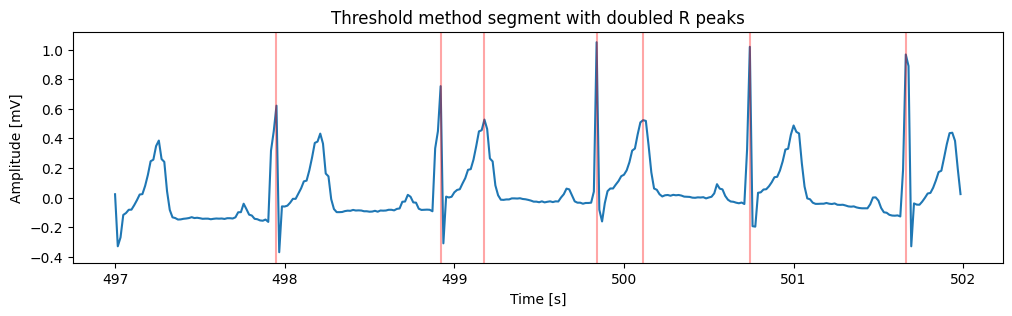

In [90]:
plot_segment(ecg, 497, 502, r_peaks, title='Threshold method segment with doubled R peaks')

# Pomocí konvoluce

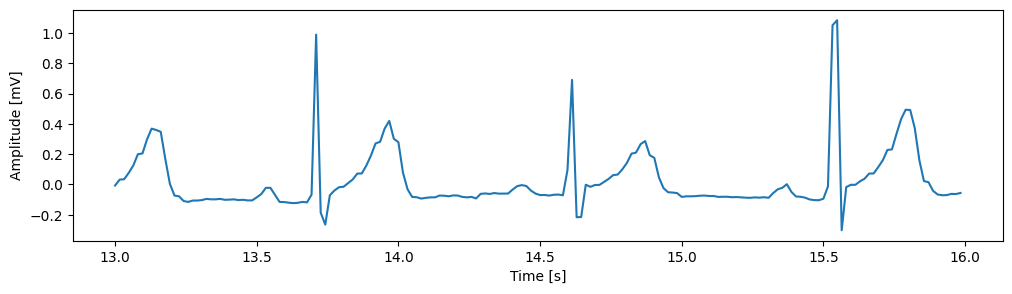

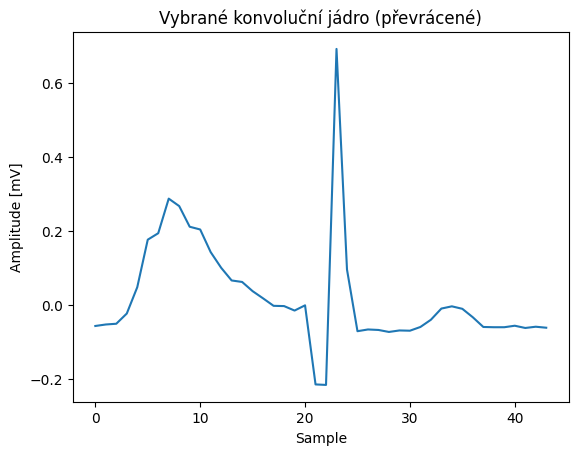

In [200]:
plot_segment(ecg, 13, 16)

def detect_r_peaks_convolution(ecg, matched_filter, threshold = 0.5):
  convolved = np.convolve(ecg, matched_filter, mode='same')
  peaks = detect_peaks(convolved)
  
  # Apply a threshold to detect the R peaks
  convolved_peaks = detect_peaks(convolved)
  r_peak_locs = [i for i in convolved_peaks if convolved[i] > threshold]

  return r_peak_locs

def create_matched_filter(ecg, start, end):
  qrs_template = ecg[start:end]
  qrs_template /= np.sqrt(np.sum(qrs_template**2))
  qrs_template = qrs_template[::-1]
  return qrs_template

# find the QRS complex start and end and round it to the nearest sample
start_of_qrs = int(14.3 * sampling_rate)
end_of_qrs = int(15 * sampling_rate)

matched_filter = create_matched_filter(ecg, start_of_qrs, end_of_qrs)

plt.plot(matched_filter)
plt.title('Vybrané konvoluční jádro (převrácené)')
plt.xlabel('Sample')
plt.ylabel('Amplitude [mV]')
plt.show()

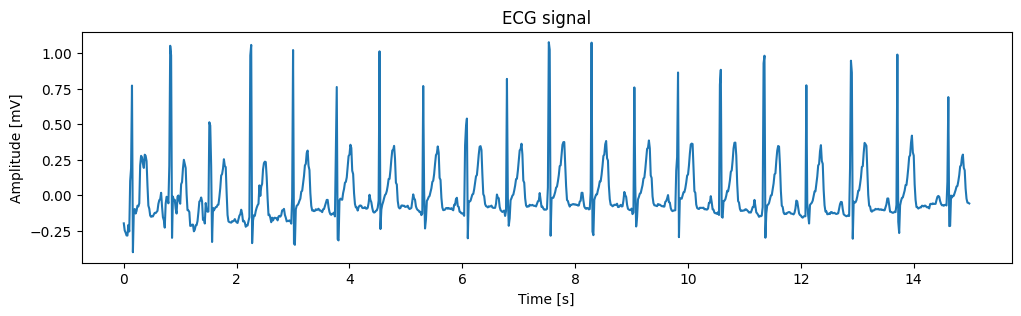

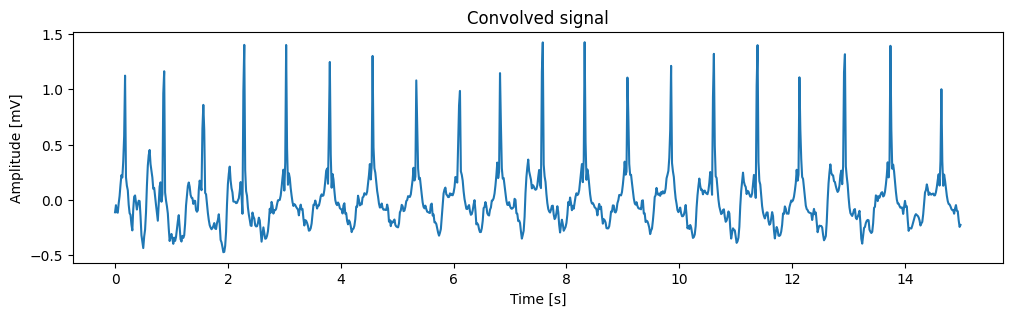

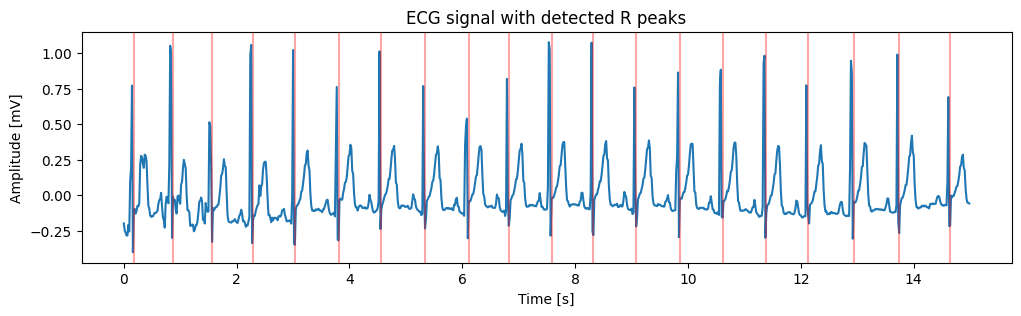

In [99]:
# Convolve the ECG signal with the matched filter
convolved_signal = np.convolve(ecg, matched_filter, mode='same')
start_time = 0
end_time = 15

plot_segment(ecg, start_time, end_time, title='ECG signal')
plot_segment(convolved_signal, start_time, end_time, title='Convolved signal')

# Apply a threshold to detect the R peaks
convolved_peaks = detect_peaks(convolved_signal)

threshold = 0.7
r_peak_locs = [i for i in convolved_peaks if convolved_signal[i] > threshold]

plot_segment(ecg, start_time, end_time, r_peak_locs, title='ECG signal with detected R peaks')

In [11]:
heart_rate = calculate_heart_rate(r_peak_locs, sampling_rate)
print('Heart rate: {:.2f} bpm'.format(heart_rate))

Heart rate: 79.77 bpm


Most/least R peaks: 47
Time of the segment with the most/least R peaks: 890.8225806451613 s
Most/least R peaks: 74
Time of the segment with the most/least R peaks: 954.516129032258 s


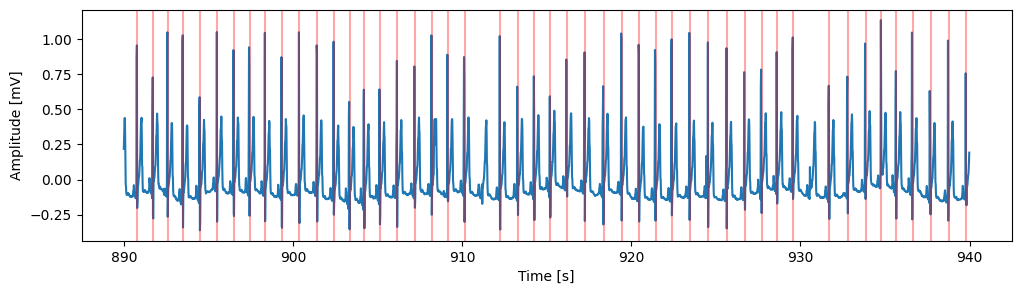

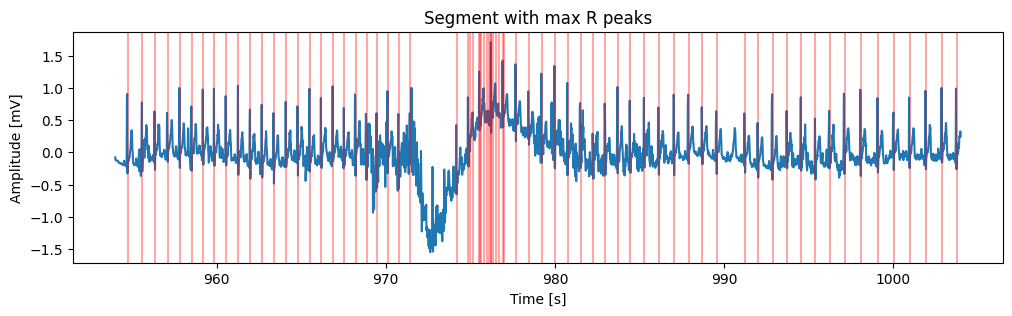

In [100]:
min_segment = find_segment_with_abnormal_r_peaks(r_peak_locs, sampling_rate, False)
max_segment = find_segment_with_abnormal_r_peaks(r_peak_locs, sampling_rate, True)

plot_segment(ecg, min_segment, min_segment + 50, r_peak_locs)
plot_segment(ecg, max_segment, max_segment + 50, r_peak_locs, title='Segment with max R peaks')

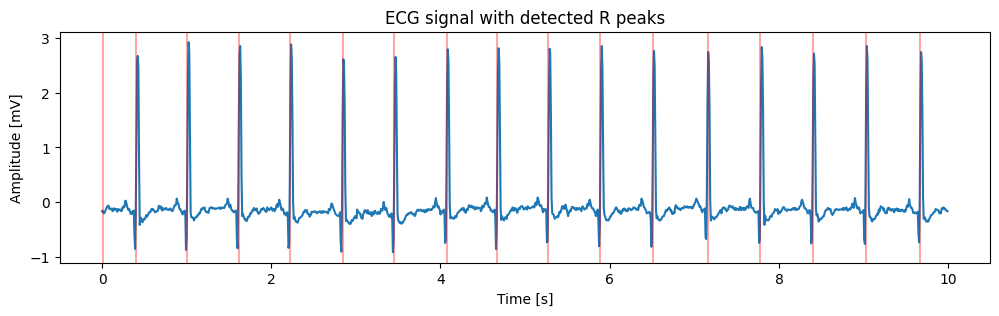

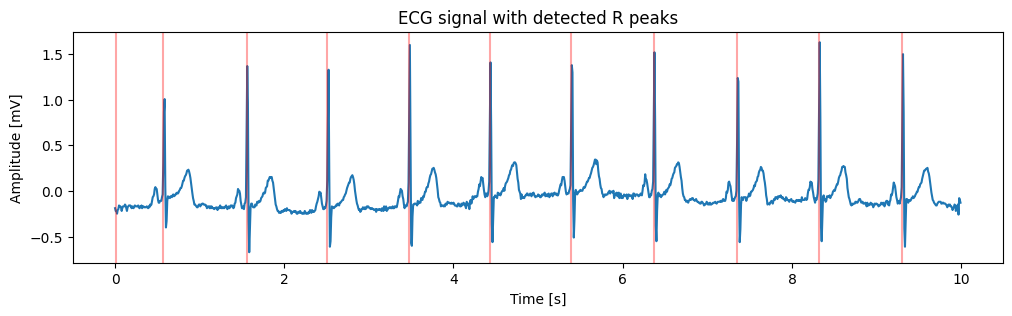

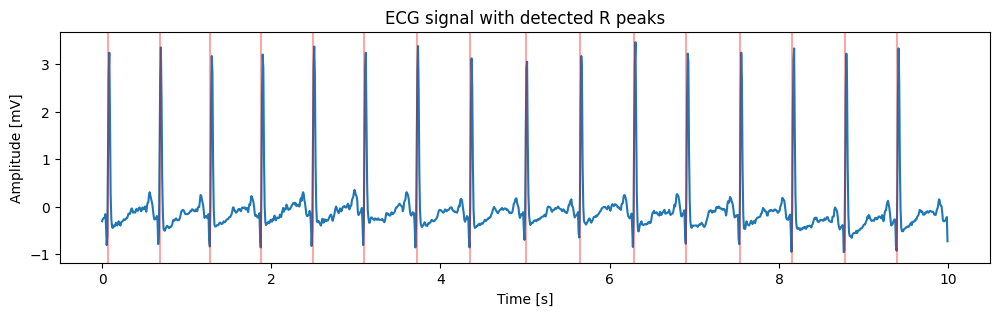

In [217]:
signals = []
for file in ["16265", "16272", "16273"]:
  signal, info = rdsamp("mit-bih/" + file, channels=None, sampfrom=0, sampto=100000)
  ann = rdann("mit-bih/" + file, extension="atr")
  signal = signal[:, 0]
  sr = info["fs"]
  plot_segment(signal, 0, 10, ann.sample, sampling_rate=sr,title="ECG signal with detected R peaks")
  signals.append((signal, sr, ann))



#   total = ann.sample.size
#   correct = 0
#   wrong = 0
#   for peak in peaks:
#       detected = False
#       for true_peak in ann.sample:
#           delta = (true_peak+1) / (peak+1)
#           deltap = np.abs(1-delta)
#           if deltap < threshold:
#               detected = True
#               break

#       if detected:
#           correct += 1
#       else:
#           wrong += 1

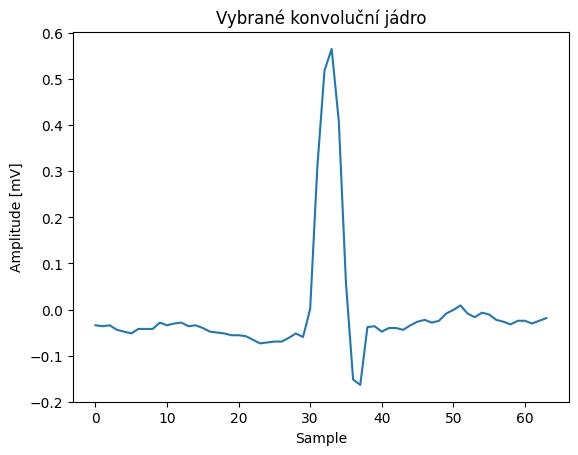

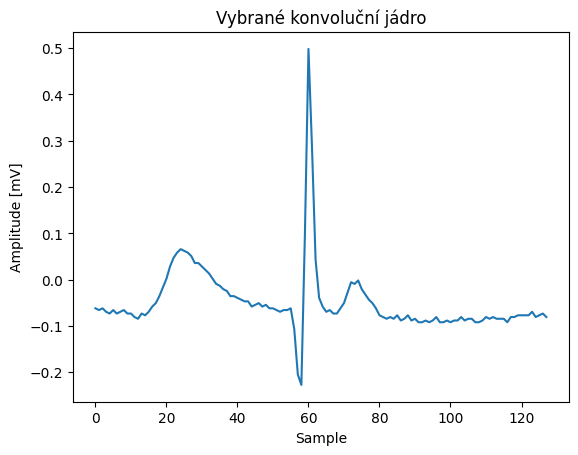

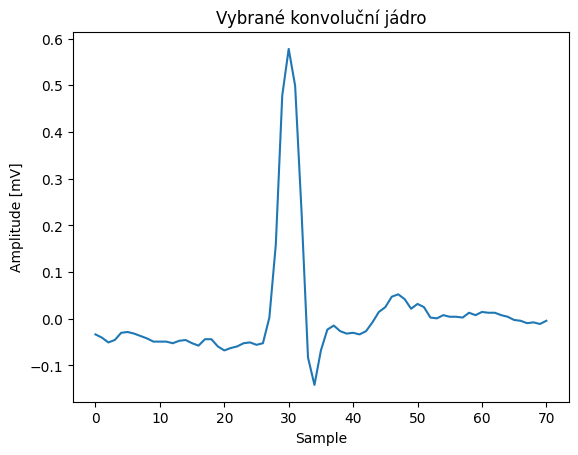

In [218]:
matched_filters = [
  create_matched_filter(signals[0][0], int(2 * signals[0][1]), int(2.5 * signals[0][1])),
  create_matched_filter(signals[1][0], int(2 * signals[1][1]), int(3 * signals[1][1])),
  create_matched_filter(signals[2][0], int(2.2 * signals[2][1]), int(2.75 * signals[2][1]))
]

for filt in matched_filters:
  plt.plot(filt)
  plt.title("Vybrané konvoluční jádro")
  plt.xlabel('Sample')
  plt.ylabel('Amplitude [mV]')
  plt.show()

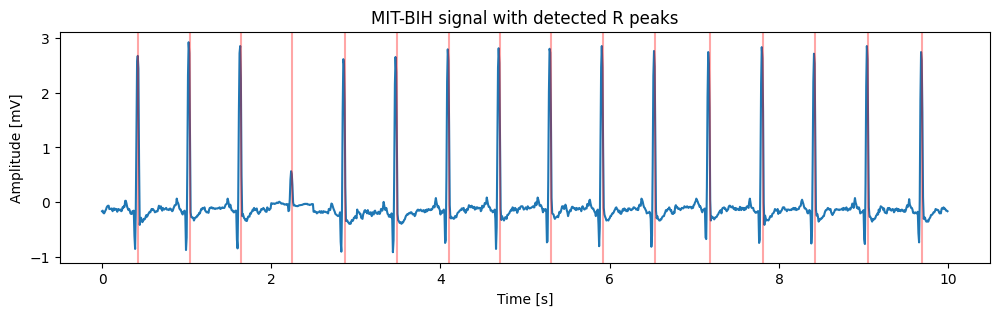

Heart rate: 103.45 bpm
Number of R peaks: Correct: 1304, Wrong: 6, Total: 1317


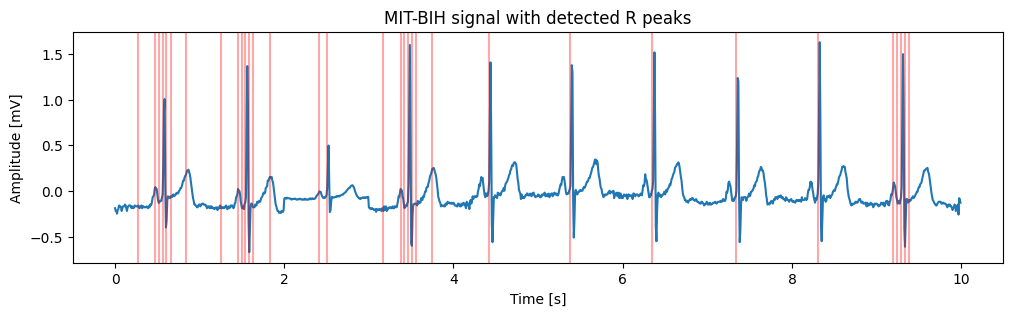

Heart rate: 1023.18 bpm
Number of R peaks: Correct: 947, Wrong: 3463, Total: 997


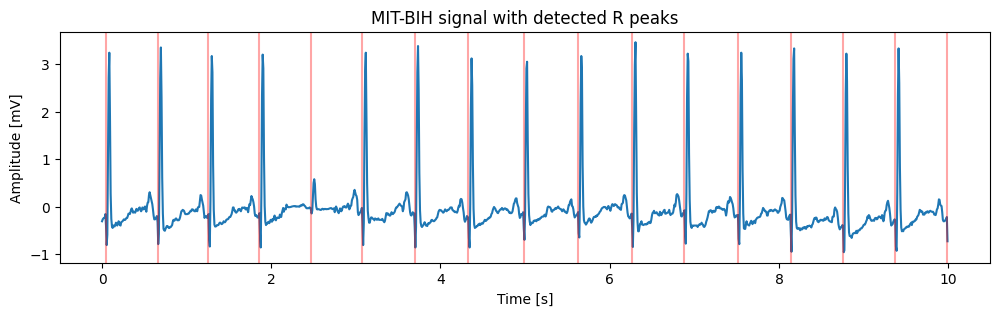

Heart rate: 113.58 bpm
Number of R peaks: Correct: 1237, Wrong: 43, Total: 1243


In [223]:
for i, (signal, sr, ann) in enumerate(signals):
  r_peaks = detect_r_peaks_convolution(signal, matched_filters[i])

  # count the number of correctly detected R peaks
  correct = 0
  total = 0

  to_test_peaks = r_peaks.copy()
  for ann_peak in ann.sample:
    if ann_peak >= len(signal): break

    total += 1
    for peak in to_test_peaks:
      if abs(ann_peak - peak) < 0.1 * sr:
        correct += 1
        to_test_peaks.remove(peak)
        break

  
  plot_segment(signal, 0, 10, r_peaks, sampling_rate=sr, title="MIT-BIH signal with detected R peaks")
  print('Heart rate: {:.2f} bpm'.format(calculate_heart_rate(r_peaks, sr)))
  print("Number of R peaks: Correct: {}, Wrong: {}, Total: {}".format(correct, len(to_test_peaks), total))

# Korelace EKG signálů

Dominant sampling rate: 15 Hz
Sampling rates: [15, 15, 31, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]


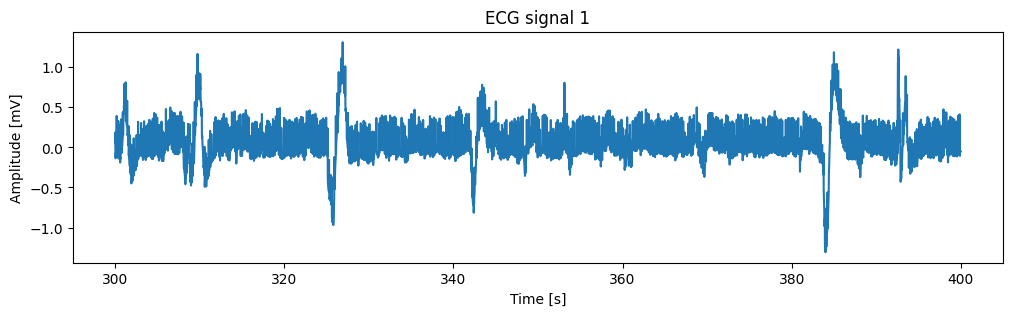

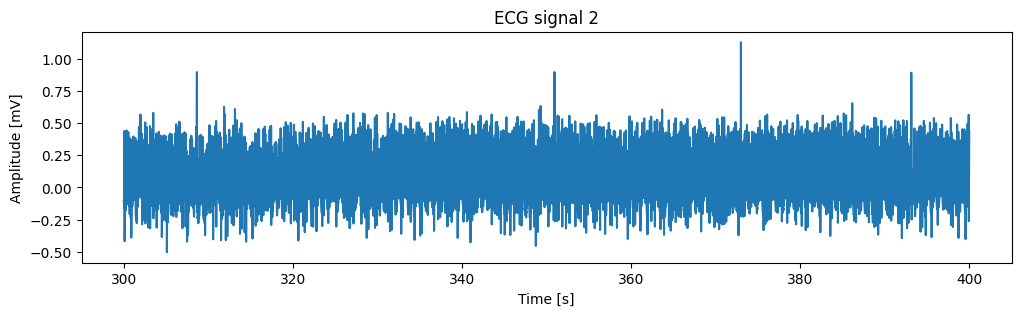

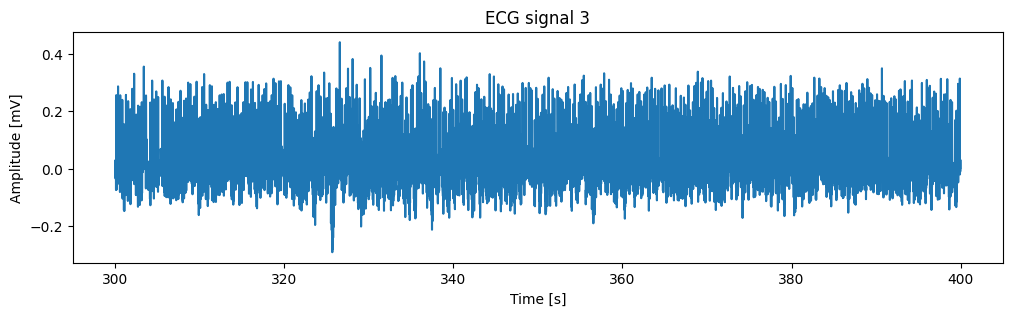

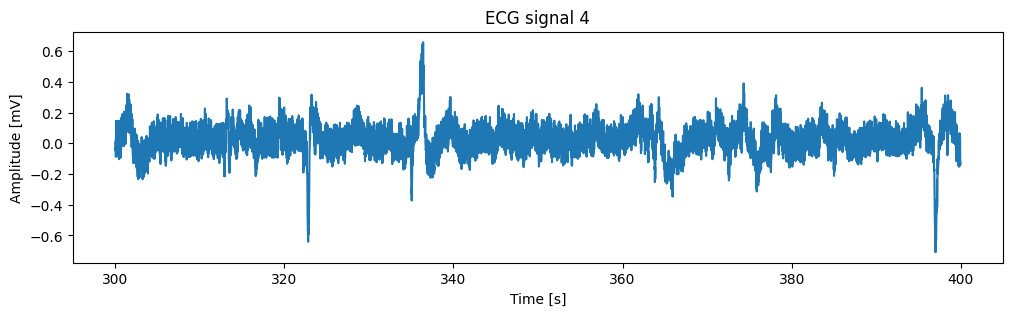

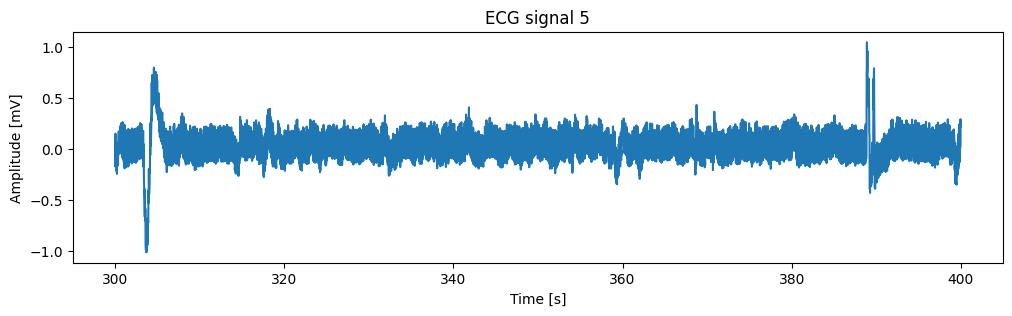

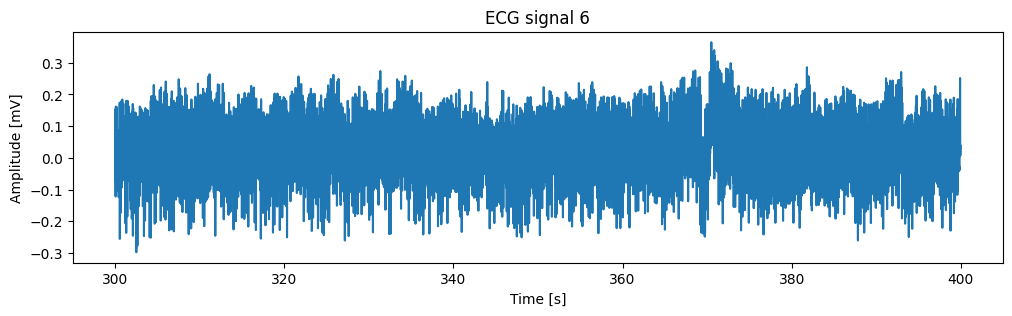

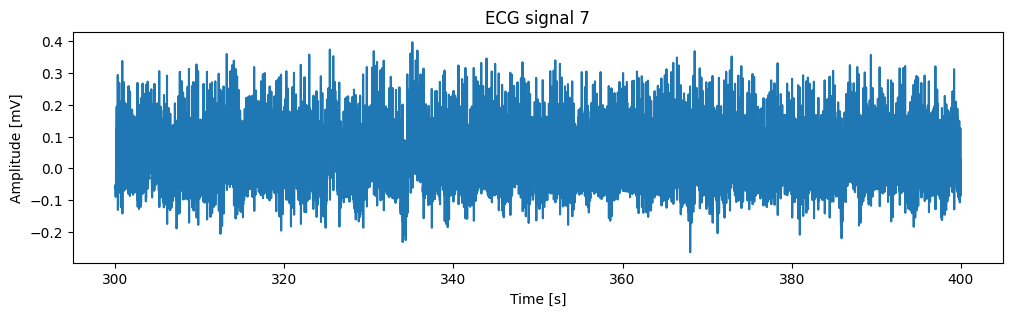

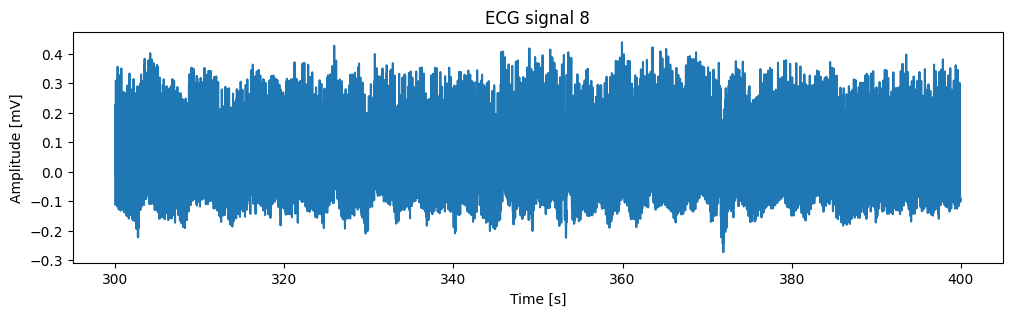

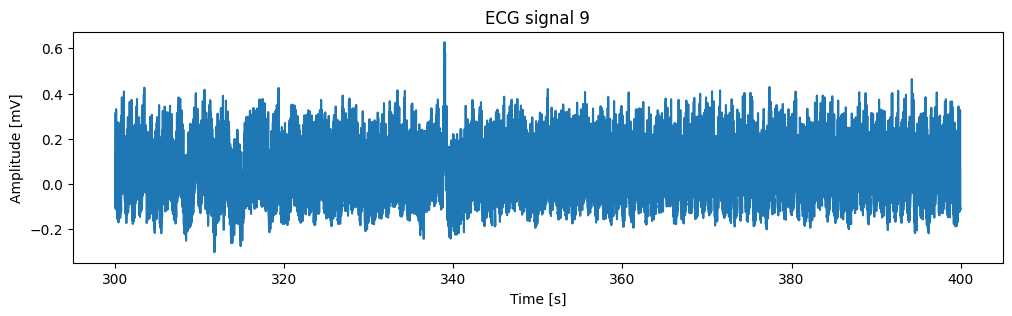

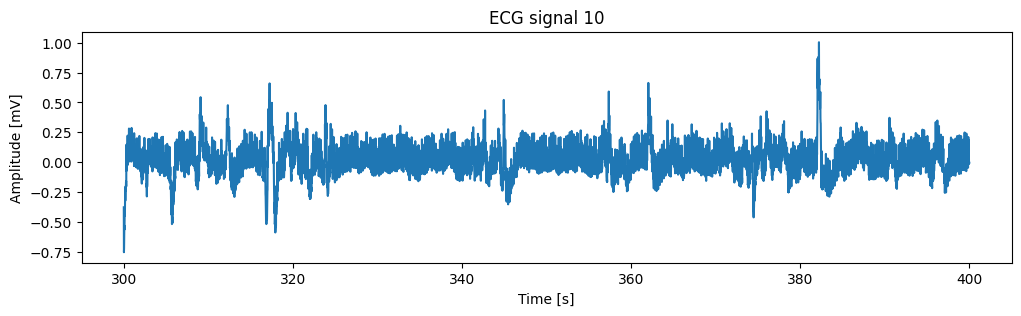

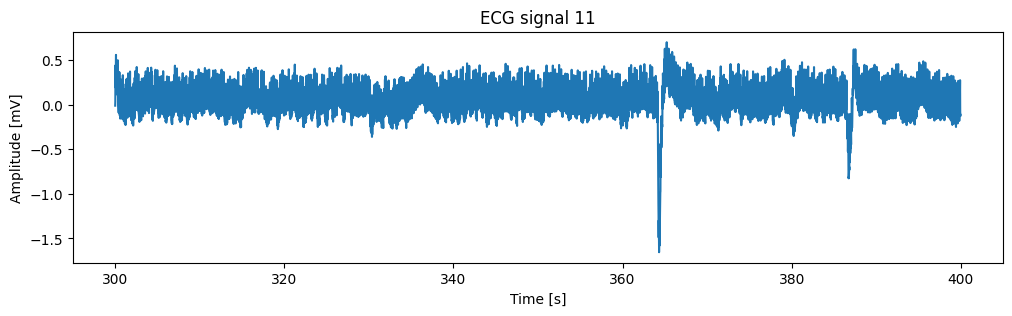

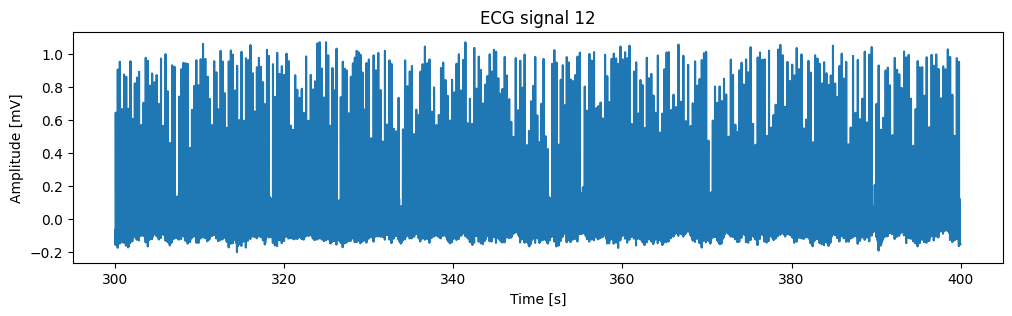

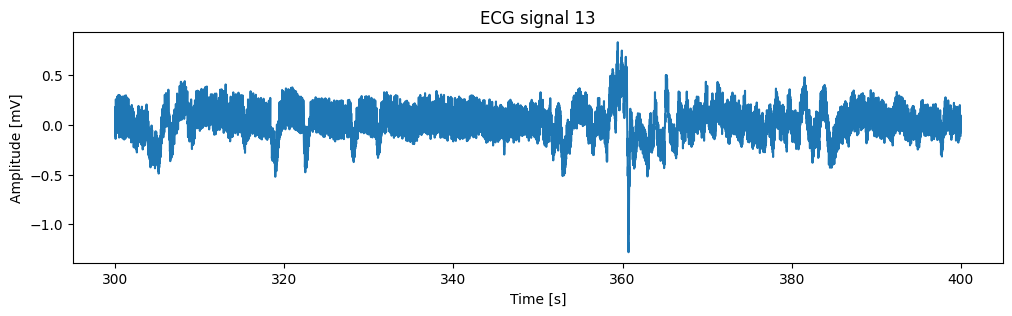

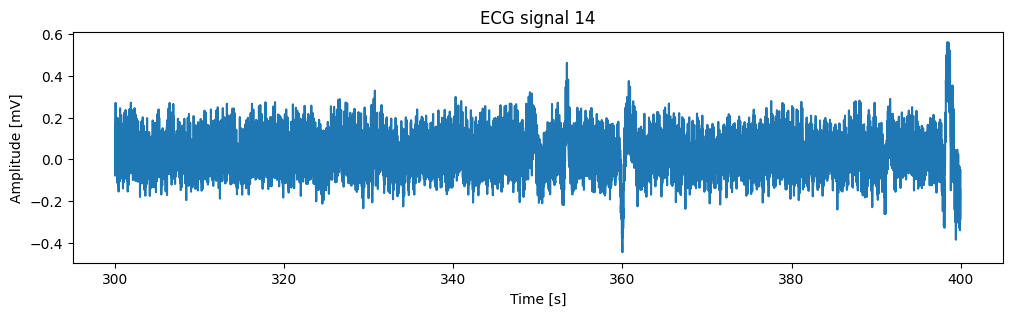

R peaks: [10, 8, 2, 77, 2, 7, 10, 12, 3, 11, 15, 3, 6, 24]


In [147]:
from scipy.signal import resample, decimate, correlate

ecgs = []
for i in range(1, 17):
  if i == 15 or i == 13: continue
  signal, fields = rdsamp("data/drive" + ("0" if i < 10 else "") + str(i), channels=[0])
  ecgs.append((signal[:,0], int(fields['fs'])))

# flip the first ECG around the x-axis
ecgs[0] = (ecgs[0][0] * -1, ecgs[0][1])
# find the dominant sampling rate
sampling_rates = [i[1] for i in ecgs]
dominant_sampling_rate = max(set(sampling_rates), key=sampling_rates.count)
print('Dominant sampling rate: {} Hz'.format(dominant_sampling_rate))
print("Sampling rates: {}".format(sampling_rates))

# resample the ECG signals to dominant sampling rate
resampled_ecgs = []
for i in range(len(ecgs)):
  if ecgs[i][1] == dominant_sampling_rate:
    resampled_ecgs.append(ecgs[i][0])
  else:
    if ecgs[i][1] > dominant_sampling_rate:
      resampled_ecgs.append(resample(ecgs[i][0], int(len(ecgs[i][0]) * dominant_sampling_rate / ecgs[i][1])))
    else:
      resampled_ecgs.append(decimate(ecgs[i][0], int(ecgs[i][1] / dominant_sampling_rate)))


start_time = 300
end_time = 400

for i in range(0, len(ecgs)):
  plot_segment(resampled_ecgs[i], start_time, end_time, title='ECG signal {}'.format(i + 1))

resampled_ecgs = [i[start_time * dominant_sampling_rate:end_time * dominant_sampling_rate] for i in resampled_ecgs]



# find the first r peak in each ECG
r_peaks = []
for i in range(len(resampled_ecgs)):
  r_peaks.append(detect_r_peaks(resampled_ecgs[i], threshold=0.2 ,first_only=True))

print("R peaks: {}".format(r_peaks))

# cut the signals from the first r peak to the end
ecgs = [i[r_peaks[j]:] for j, i in enumerate(resampled_ecgs)]

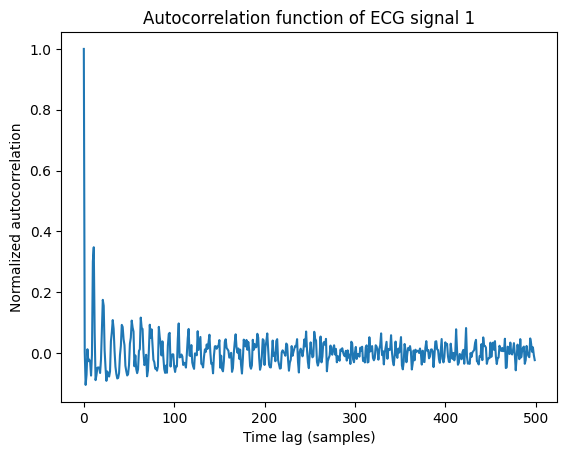

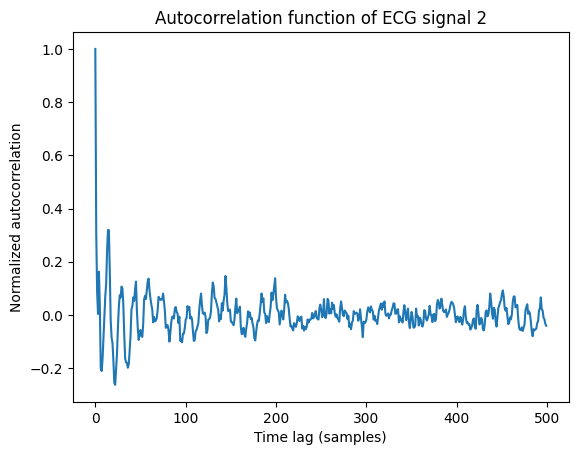

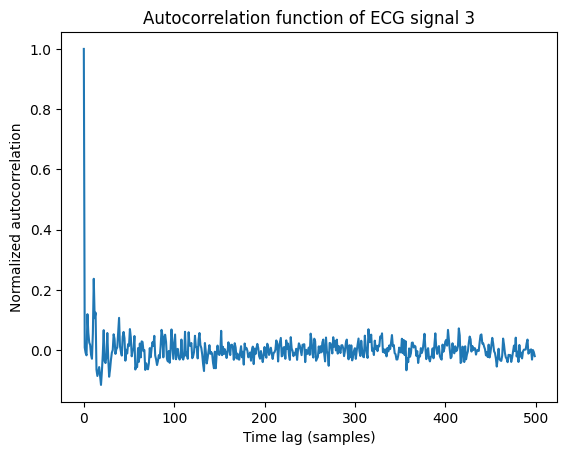

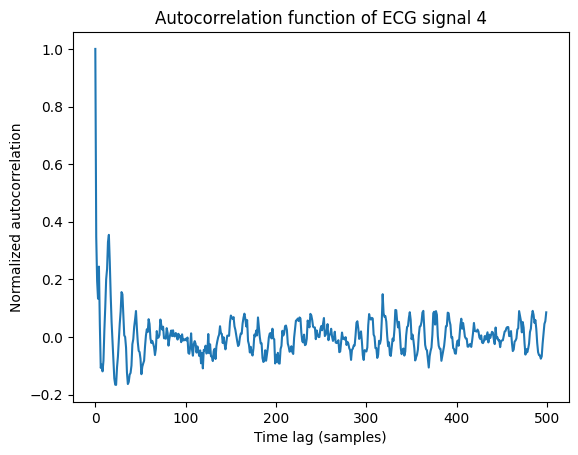

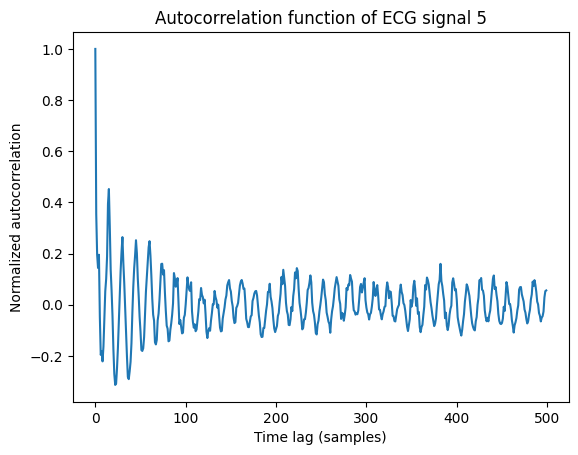

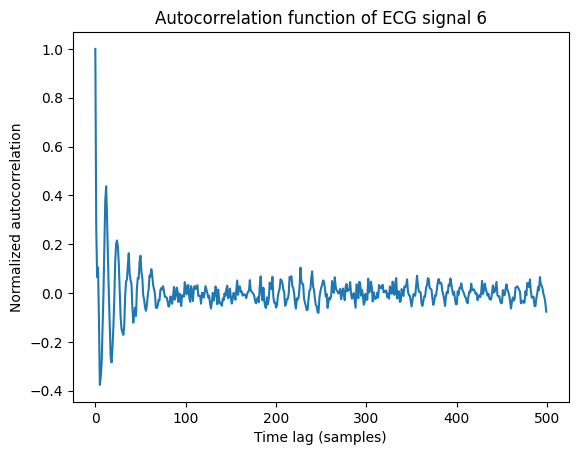

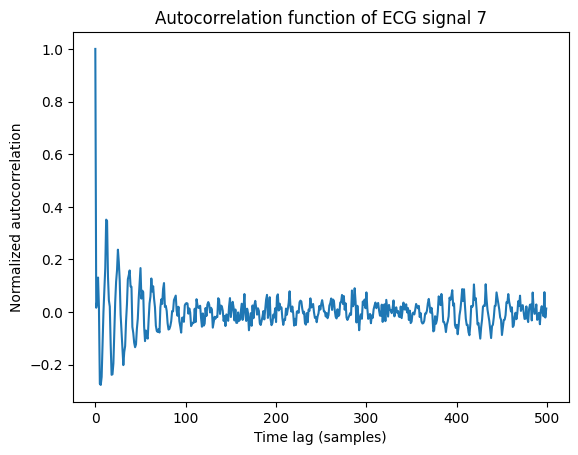

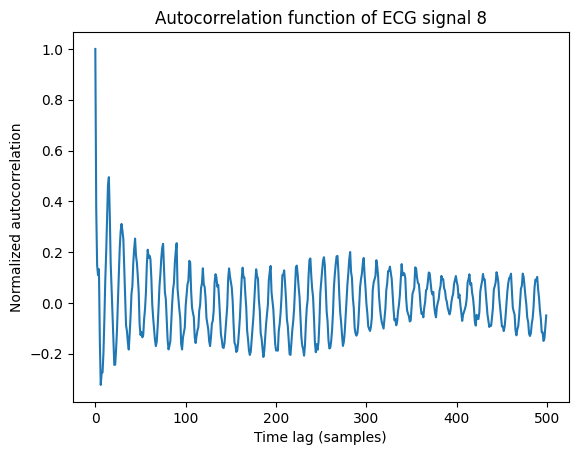

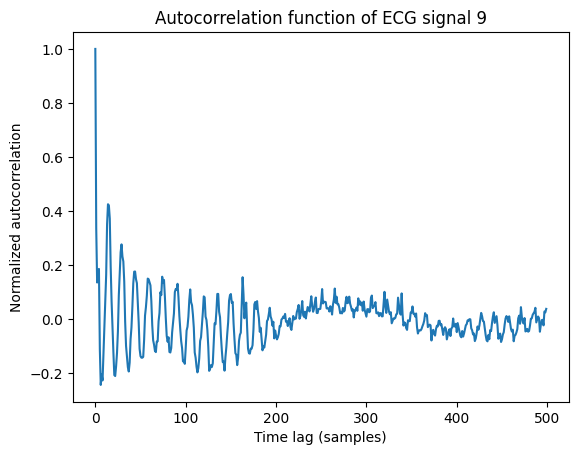

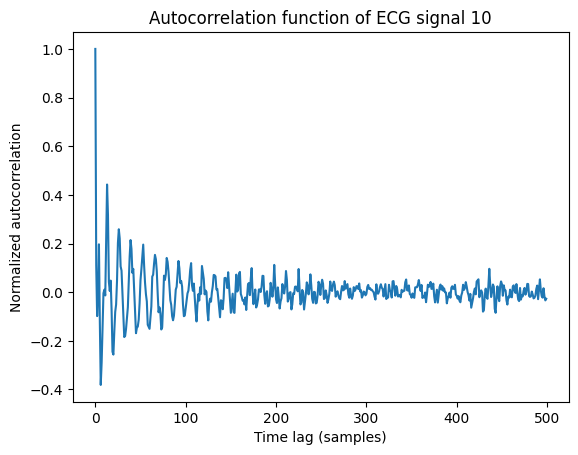

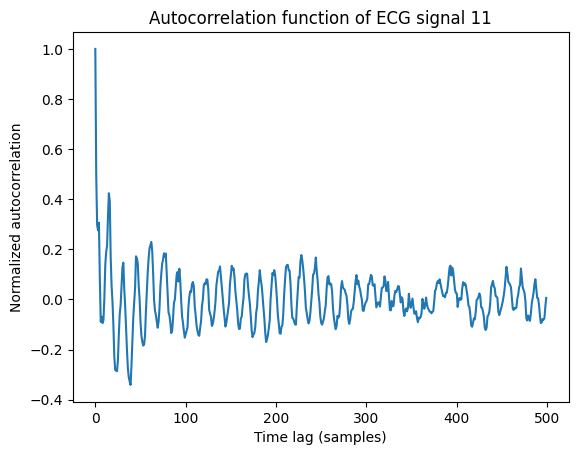

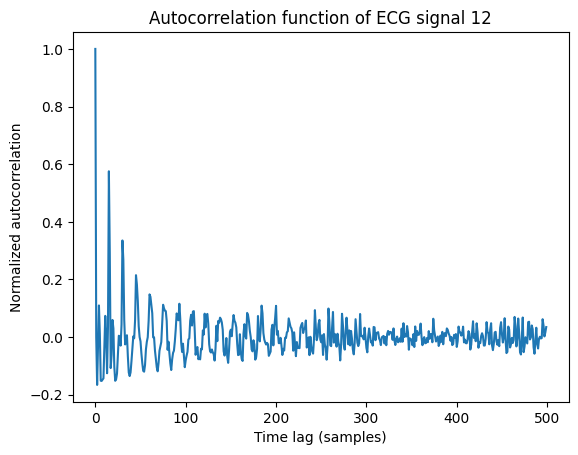

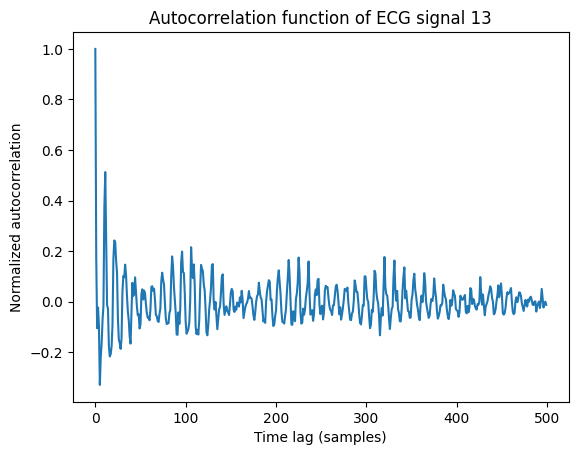

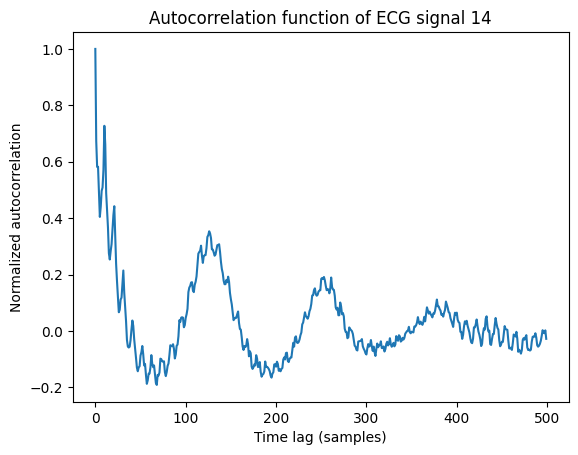

In [148]:
# autocorrelation analysis
for i in range(0, len(ecgs)):
  autocorr = correlate(ecgs[i], ecgs[i], mode='full')

  autocorr = autocorr[len(ecgs[i])-1:]

  # Normalize the autocorrelation function to the range -1 to 1
  autocorr = autocorr / np.max(autocorr)

  # Plot the autocorrelation function
  plt.plot(autocorr[0:500])
  plt.title('Autocorrelation function of ECG signal {}'.format(i + 1))
  plt.xlabel('Time lag (samples)')
  plt.ylabel('Normalized autocorrelation')
  plt.show() 

Min length: 1423
14
Min correlation: 0.00003
Max correlation: 0.09


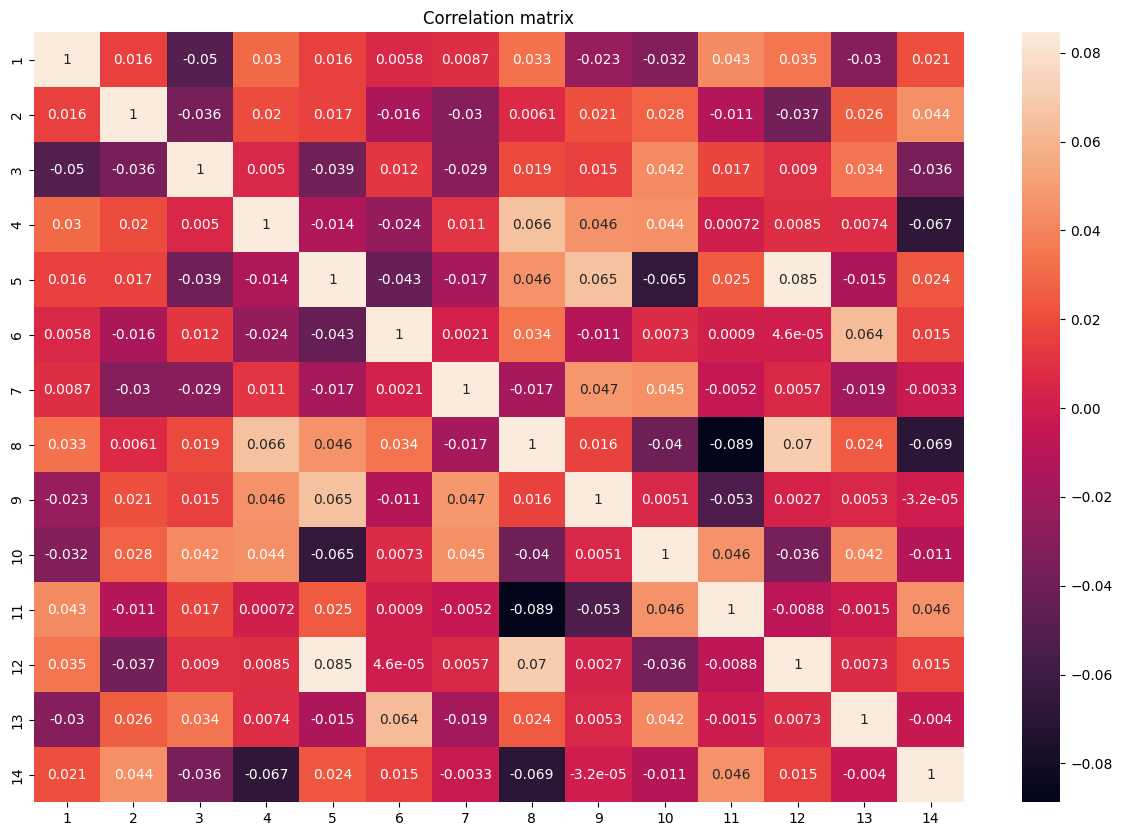

In [166]:
# find the shortest signal
min_length = min([len(i) for i in ecgs])

print("Min length: {}".format(min_length))

cut_signals = np.ndarray((len(ecgs), min_length))
# cut all signals to the same length
for i in range(len(ecgs)):
  cut_signals[i] = ecgs[i][:min_length]

print(len(cut_signals))

corr_matrix = np.corrcoef(cut_signals)

min_val = np.min(corr_matrix)
# max value that is not 1
max_val = np.max(corr_matrix[corr_matrix < 0.9])

min_cor = np.min(abs(corr_matrix))
# max value that is not 1
max_cor = np.max(abs(corr_matrix[corr_matrix < 0.9]))

# print with .format to 2 decimal places
print("Min correlation: {:.5f}".format(min_cor))
print("Max correlation: {:.2f}".format(max_cor))

import seaborn as sns

plt.figure(figsize=(15, 10))
plt.title("Correlation matrix")

sns.heatmap(
  corr_matrix,
  annot=True,
  xticklabels=list(range(1, 15)), 
  yticklabels=list(range(1, 15)),
  vmin=min_val,
  vmax=max_val
)

plt.show()